In [1]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from numpy.random import *
from scipy import ceil, complex64, float64, hamming, zeros
from matplotlib import pylab as plt
import xml.etree.ElementTree as et
import argparse
import time
from cmf.cmfpn import CMFPN
from matplotlib import pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
method_name_small = 'cmf'
method_name_capital = 'CMF'
experiment_name = 'estimation_10_revised'
parser = argparse.ArgumentParser(description='structure detection test')
parser.add_argument('-s', '--seed_number', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=0, \
                    type=int, \
                    choices=None, \
                    help='seed_number', \
                    metavar=None)
parser.add_argument('-d', '--dat_dir', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default='../dat/estimation', \
                    type=str, \
                    choices=None, \
                    help='Directory where npy files will be stored.', \
                    metavar=None)
parser.add_argument('-n', '--dat_npz', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.npz', \
                    type=str, \
                    choices=None, \
                    help='npz file name', \
                    metavar=None)
parser.add_argument('-png', '--dat_png', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.png', \
                    type=str, \
                    choices=None, \
                    help='png file name', \
                    metavar=None)
parser.add_argument('-pdf', '--dat_pdf', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.pdf', \
                    type=str, \
                    choices=None, \
                    help='pdf file name', \
                    metavar=None)

_StoreAction(option_strings=['-pdf', '--dat_pdf'], dest='dat_pdf', nargs='?', const=None, default='cmf_estimation_10_revised_201710131923.pdf', type=<class 'str'>, choices=None, help='pdf file name', metavar=None)

In [3]:
args = parser.parse_args([])

In [4]:
seed(args.seed_number)


In [5]:
n_tests = 1
n_criteria = 5
n_samples_list = [100, 1000, 10000]
n_samples_for_transfer = 200
data_dim = 12
convolution_width = 10
n_components_list = [2, 4]
response_SD = 10000.0 * np.ones([data_dim])
noise_SD = 1.0 * np.ones([data_dim])
signal_laplace_scale = 0.01 
loop_max = 10000
convergence_threshold = 0.0001

In [6]:
mu_joint_loss_transition = np.full([len(n_components_list), len(n_samples_list), 2 * loop_max], np.nan)
bfgs_joint_loss_transition = np.full([len(n_components_list), len(n_samples_list), 2 * loop_max], np.nan)
transfer_joint_loss_transition = np.full([len(n_components_list), len(n_samples_list), loop_max], np.nan)
mu_elapsed_time_transition = np.full([len(n_components_list), len(n_samples_list), 2 * loop_max], np.nan)
bfgs_elapsed_time_transition = np.full([len(n_components_list), len(n_samples_list), 2 * loop_max], np.nan)
transfer_elapsed_time_transition = np.full([len(n_components_list), len(n_samples_list), loop_max], np.nan)

(2, 3)
n_samples 100
(100, 2) (10, 2, 12)
n_samples 1000
(1000, 2) (10, 2, 12)
n_samples 10000
(10000, 2) (10, 2, 12)
n_samples 100
(100, 4) (10, 4, 12)
n_samples 1000
(1000, 4) (10, 4, 12)
n_samples 10000
(10000, 4) (10, 4, 12)


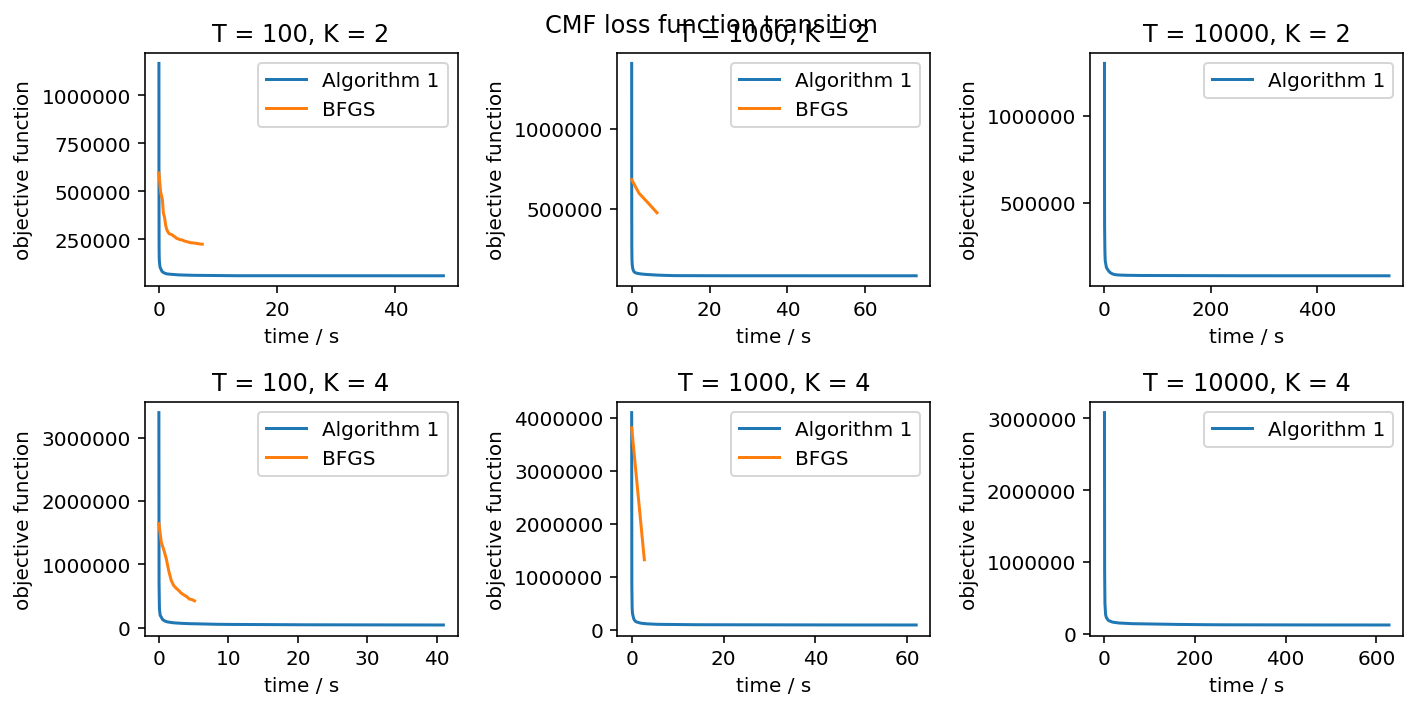

In [7]:
# %pdb
# import warnings
# warnings.filterwarnings('error')
fig, ax = plt.subplots(nrows=len(n_components_list), ncols=len(n_samples_list), figsize=(10,5))
print(ax.shape)
xlabel = 'time / s'
ylabel = 'objective function'
for i_n_components, n_components in enumerate(n_components_list):
    for i_n_samples, n_samples in enumerate(n_samples_list):
        print('n_samples', n_samples)
        true_signal = np.random.laplace(0, signal_laplace_scale, [n_samples, n_components])
        true_response = np.random.normal(0, response_SD[np.newaxis, np.newaxis, :], [convolution_width, n_components, data_dim])
        print(true_signal.shape, true_response.shape)
        X = np.random.normal(CMFPN.convolute(true_signal, true_response), noise_SD)
        arg_dict = dict(
            convolution_width = convolution_width,
            n_components = n_components,
            signal_l1_weight = 1.0 / signal_laplace_scale,
            signal_l2_weight = 0.0,
            loss_weight = 1.0 / (noise_SD * noise_SD),
            response_l2_weight = 1.0 / (response_SD * response_SD),
            response_l1_weight = 0.0 / np.mean(np.abs(X), axis=0),
            convergence_threshold = convergence_threshold,
            loop_max = loop_max)
        factorizer = CMFPN(method='mu', **arg_dict)
        filtre = np.ones(X.shape)
        factorizer.fit(X, filtre)
        mu_elapsed_time_transition[i_n_components, i_n_samples, :] = factorizer.elapsed_time_transition.reshape(loop_max * 2)
        mu_joint_loss_transition[i_n_components, i_n_samples, :] = factorizer.joint_loss_transition.reshape(loop_max * 2)/np.prod(X.shape)
        ax[i_n_components, i_n_samples].plot(mu_elapsed_time_transition[i_n_components, i_n_samples, :], mu_joint_loss_transition[i_n_components, i_n_samples, :], label = 'Algorithm 1')
        factorizer = CMFPN(method='bfgs', **arg_dict)
        factorizer.fit(X, filtre)
        bfgs_elapsed_time_transition[i_n_components, i_n_samples, :] = factorizer.elapsed_time_transition.reshape(loop_max * 2)
        bfgs_joint_loss_transition[i_n_components, i_n_samples, :] = factorizer.joint_loss_transition.reshape(loop_max * 2)/np.prod(X.shape)
        if np.prod(np.isnan(bfgs_joint_loss_transition[i_n_components, i_n_samples, :])) == 0:
            ax[i_n_components, i_n_samples].plot(bfgs_elapsed_time_transition[i_n_components, i_n_samples, :], bfgs_joint_loss_transition[i_n_components, i_n_samples, :], label='BFGS')
        ax[i_n_components, i_n_samples].set_xlabel(xlabel)
        ax[i_n_components, i_n_samples].set_ylabel(ylabel)
        ax[i_n_components, i_n_samples].title.set_text('T = '+str(n_samples)+', K = '+str(n_components))
        ax[i_n_components, i_n_samples].legend()
fig.suptitle('CMF loss function transition')
fig.tight_layout()
fig.savefig(args.dat_dir + '/' + args.dat_png, format='png')
fig.savefig(args.dat_dir + '/' + args.dat_pdf, format='pdf')


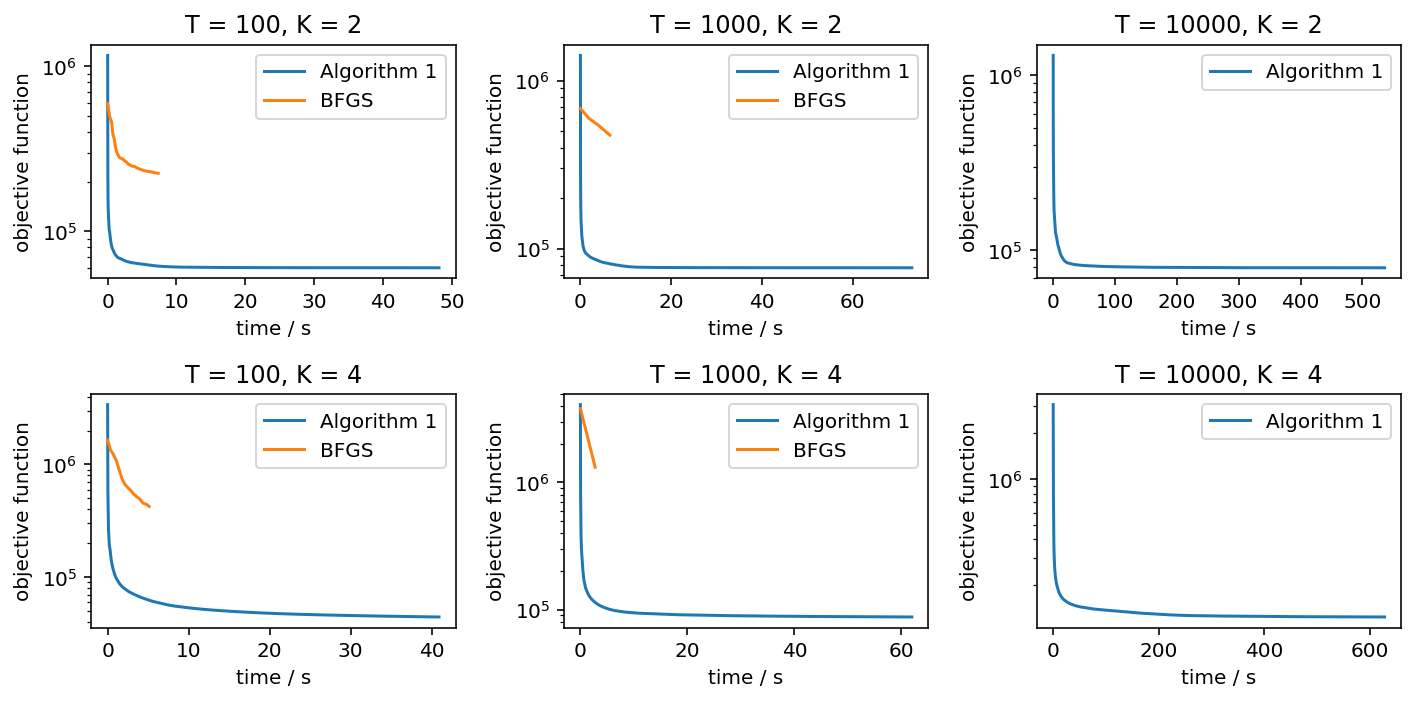

In [29]:
fig, ax = plt.subplots(nrows=len(n_components_list), ncols=len(n_samples_list), figsize=(10,5))
# fig, ax = plt.subplots(nrows=1, ncols=len(n_samples_list), figsize=(10,5))
xlabel = 'time / s'
ylabel = 'objective function'
for i_n_components, n_components in enumerate(n_components_list):
    for i_n_samples, n_samples in enumerate(n_samples_list):
        n_samples = n_samples_list[i_n_samples]
        ax[i_n_components, i_n_samples].set_yscale('log')
        ax[i_n_components, i_n_samples].plot(mu_elapsed_time_transition[i_n_components, i_n_samples, :], mu_joint_loss_transition[i_n_components, i_n_samples, :], label = 'Algorithm 1')
        if np.prod(np.isnan(bfgs_joint_loss_transition[i_n_components, i_n_samples, :])) == 0:
            ax[i_n_components, i_n_samples].plot(bfgs_elapsed_time_transition[i_n_components, i_n_samples, :], bfgs_joint_loss_transition[i_n_components, i_n_samples, :], label='BFGS')
        ax[i_n_components, i_n_samples].set_xlabel(xlabel)
        ax[i_n_components, i_n_samples].set_ylabel(ylabel)
        ax[i_n_components, i_n_samples].title.set_text('T = '+str(n_samples)+', K = '+str(n_components))
        ax[i_n_components, i_n_samples].legend()
fig.tight_layout()
# fig.suptitle('CMF loss function transition', fontsize = 16)
fig.savefig(args.dat_dir + '/' + args.dat_png, format='png')
fig.savefig(args.dat_dir + '/' + args.dat_pdf, format='pdf')


In [9]:
np.savez(args.dat_dir + '/' + args.dat_npz,
         mu_joint_loss_transition = mu_joint_loss_transition,
         bfgs_joint_loss_transition = bfgs_joint_loss_transition,
         mu_elapsed_time_transition = mu_elapsed_time_transition,
         bfgs_elapsed_time_transition = bfgs_elapsed_time_transition,
         n_samples_list = n_samples_list,
         n_components_list = n_components_list,
         convolution_width = convolution_width)
